# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
import pandas as pd
import datetime as dt

# Loading the data
df = pd.read_csv("household_power_clean.csv")


In [4]:
#convert datetime to epoch/unix time

import pandas as pd
import datetime as dt

# loading data
df = pd.read_csv("household_power_clean.csv")


# Converting datetime column to Unix time

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = (df['Datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')



# converting datetime to epoch time
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["epoch"] = df["Datetime"].apply(lambda x: int((x - dt.datetime(1970,1,1)).total_seconds()))

# To Check results
print(df.head())



   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3            Datetime  gap_monthly  \
0         1.00000        17.00000 2006-12-16 17:24:00          NaN   
1         1.00000        16.00000 2006-12-16 17:25:00          NaN

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:"ph" stands for the number of time delays to include in the model as predictor variables in linear regression for time series analysis. It establishes how much historical data or prior observations should be taken into account when forecasting the response variable's current value. The hyperparameter "mu" regulates how much regularization is performed to the model. By reducing the calculated regression coefficients toward zero, it aids in preventing overfitting.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / 10)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The following method can be used to determine the weight given to the first data point in forecasting the final (5000th) observation if we are using a straightforward exponential smoothing model with a smoothing parameter of mu = 0.9:

First data point's weight is equal to (1 - mu) * mu^(n-1)

where n is the number of observations (5000 - 1 = 4999) between the first and last data points.

When we enter mu = 0.9 and n = 4999, we obtain:

Weight of the first data point: (1 - 0.9) * 0.9^(4999) = 1.125 x 10^-8

As a result, the first data point receives relatively little weight (1.125 x 10^-8) in forecasting the final observation. This indicates that the last observation's prediction will not be significantly affected by the first data point.


**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new sample  is acquired.
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = m_tmp*tp + q_tmp #mx + b
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


Now let's visualize the results from our model.

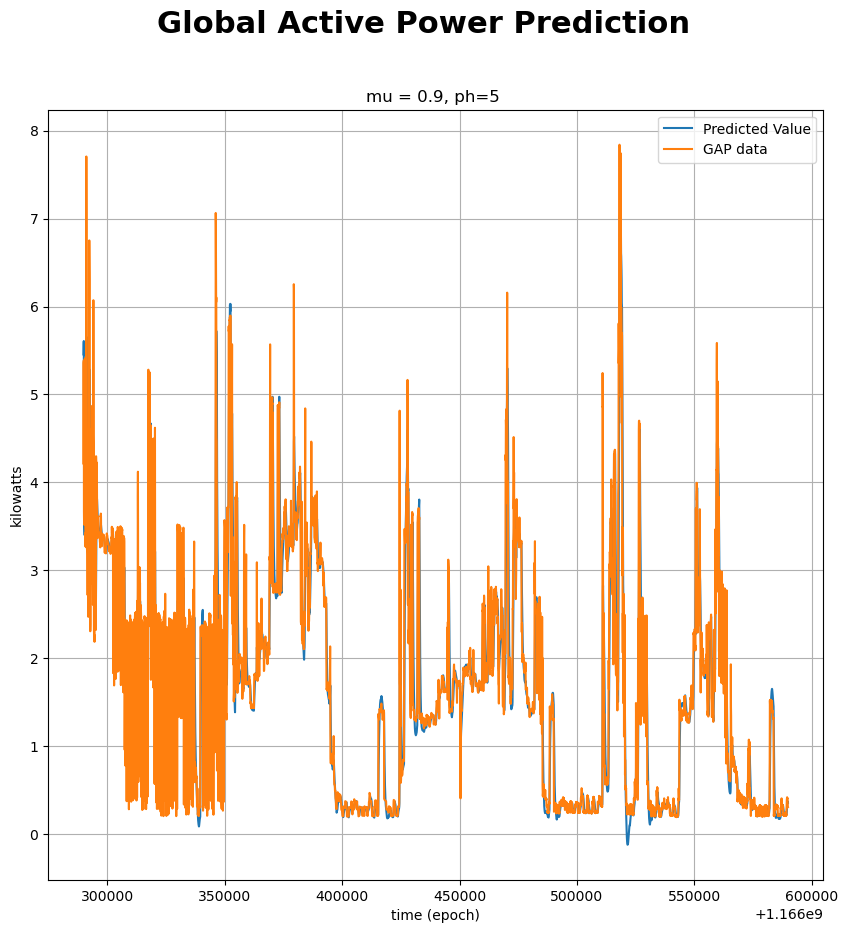

In [7]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
ax.grid()

plt.show()


It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

         unix
0  1166289840
1  1166289900
2  1166289960
3  1166290020
4  1166290080
   Global_active_power
0              4.21600
1              5.36000
2              5.37400
3              5.38800
4              3.66600


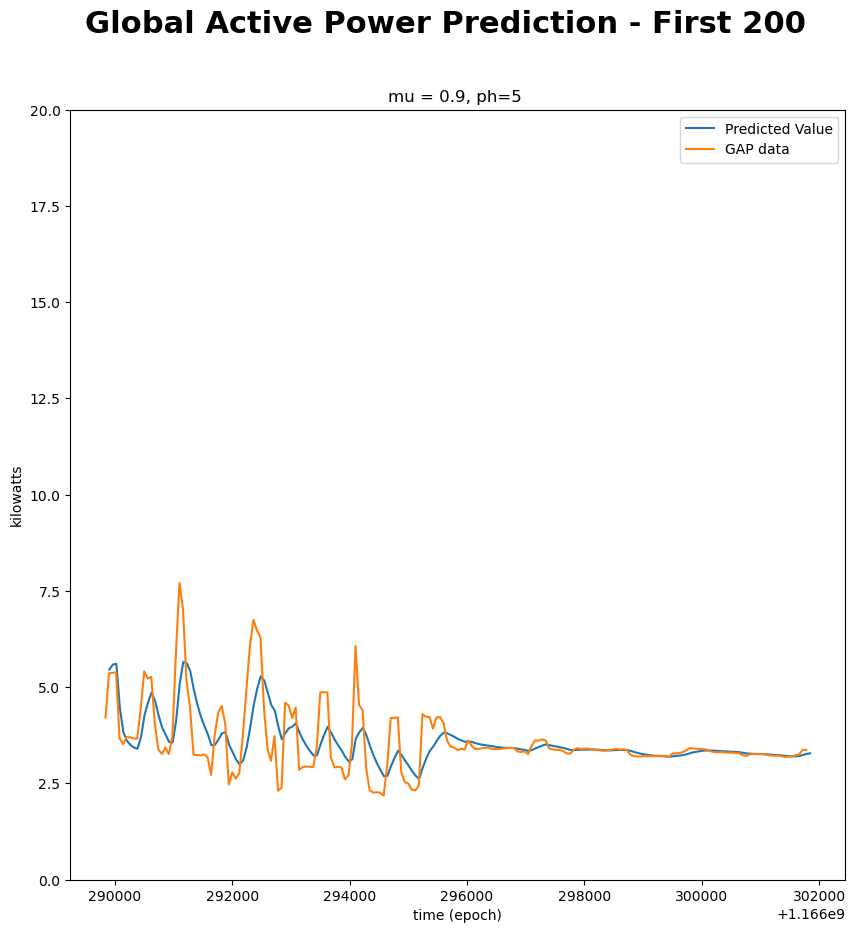

In [8]:



#first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_ylim([0, 20])  # Adjust the y-axis limits to zoom in on the data
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()




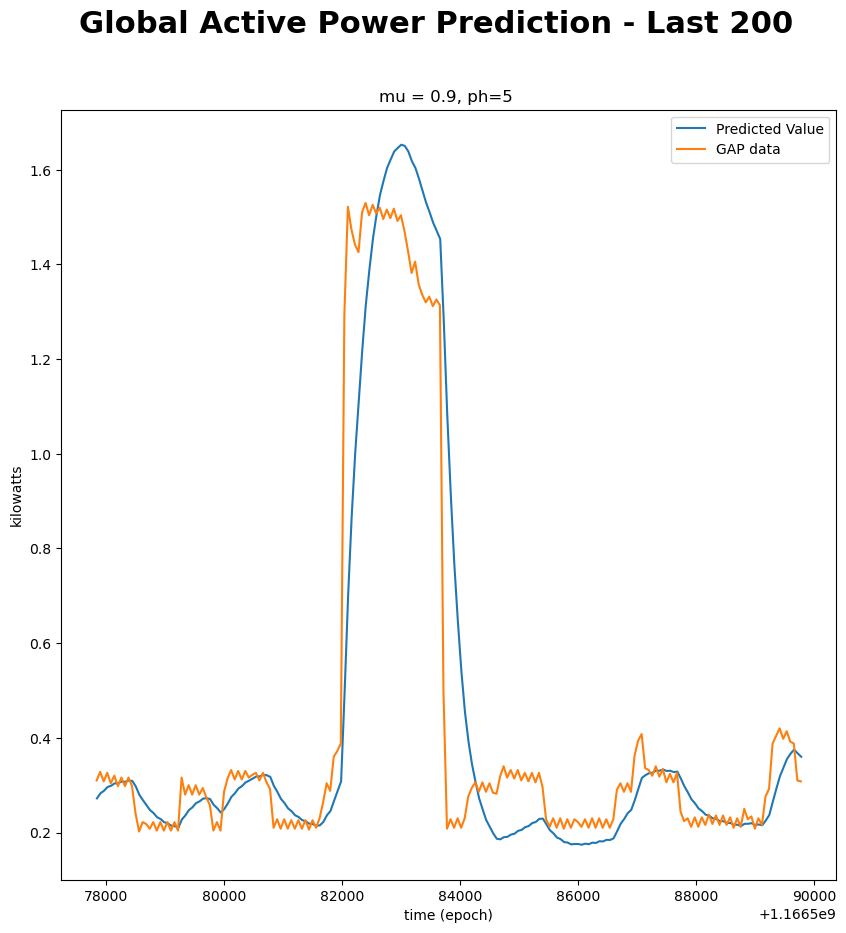

In [9]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - Last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')

ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error as mse
ph_index = round(ph/10) #this is the number of timesteps for our predictive horizon
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))

MSE is 0.17650896514073613


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With an MSE of 0.1765, the model appears to have done quite well, indicating that the predictions are fairly close to the actual data. The early and late projections do not differ noticeably, according to the charts, and the model appears to adequately reflect the general direction of the data. The predictions of the model do, however, differ from the actual numbers at times.
The average squared difference between the predicted values and the actual values is revealed by the MSE (Mean Squared Error). The performance of the model improves with decreasing MSE. The MSE of 0.1765 in this instance indicates that the model's performance is mediocre but still laudable.




**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [11]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / 10)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


In [12]:
# At every iteration of the for loop a new sample  is acquired.
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = m_tmp*tp + q_tmp #mx + b
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


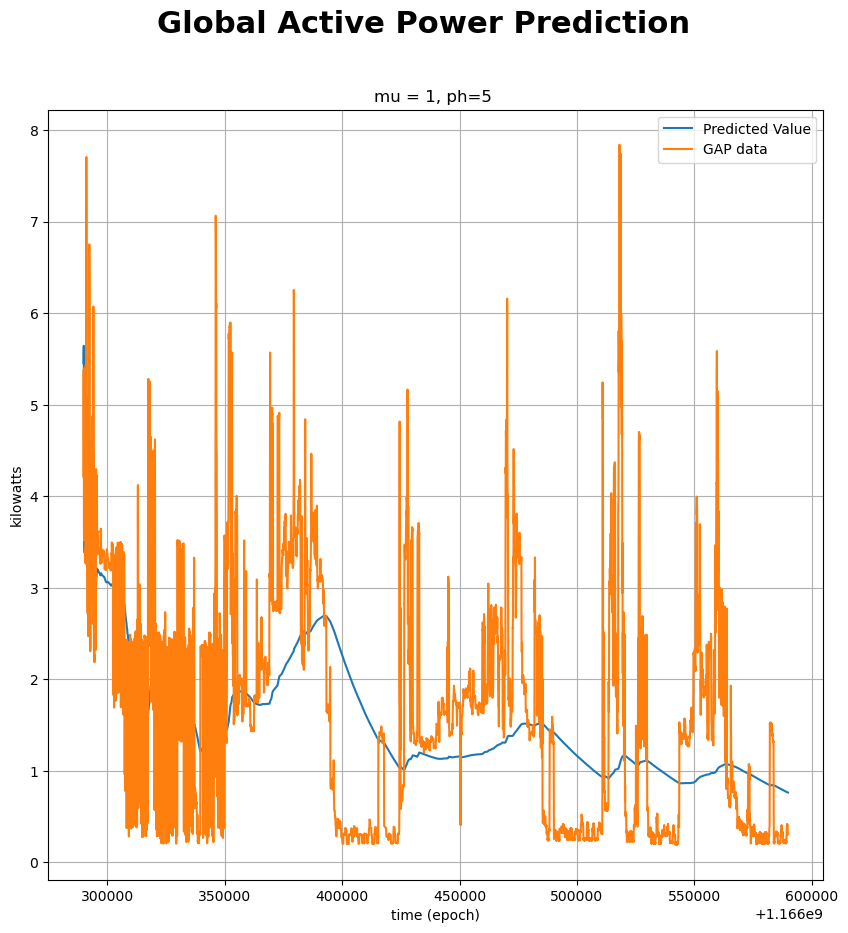

In [13]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
ax.grid()

plt.show()


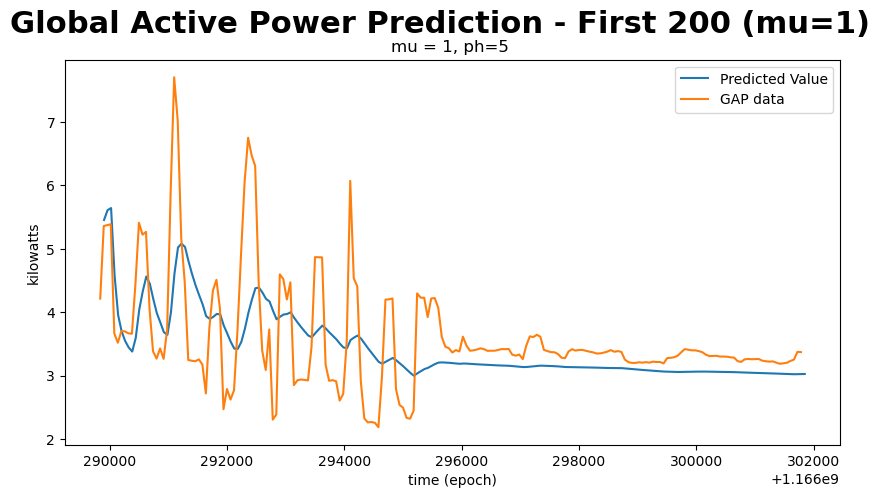

In [14]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Global Active Power Prediction - First 200 (mu=1)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()


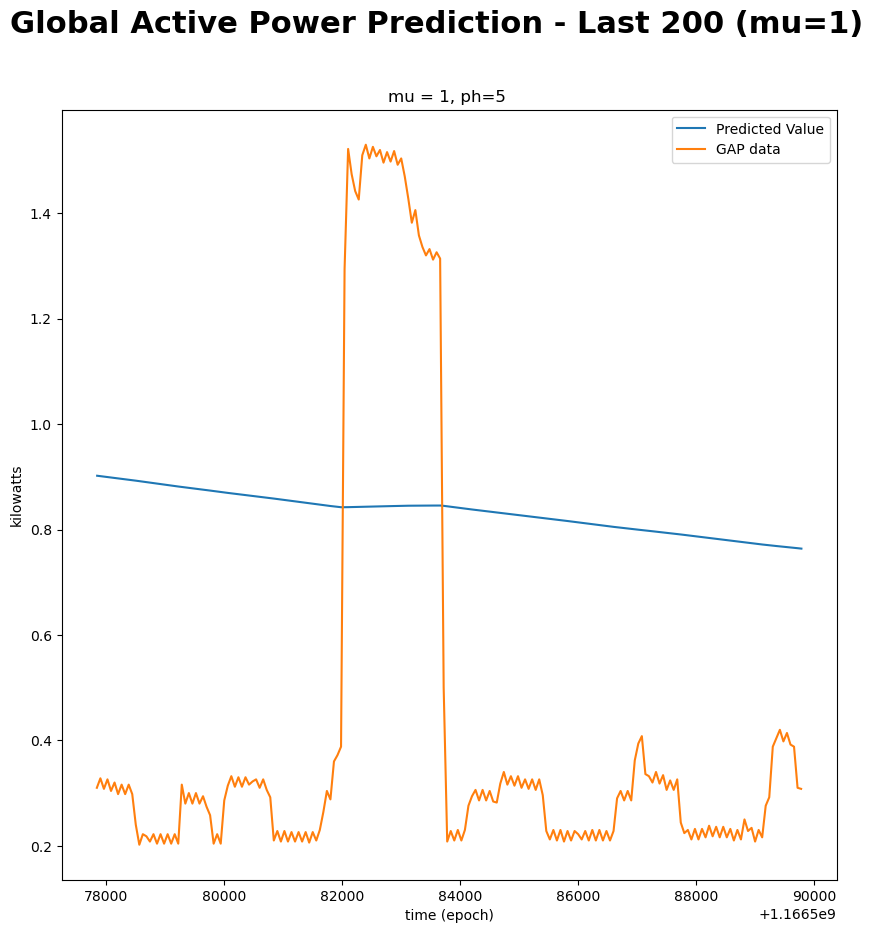

In [15]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - Last 200 (mu=1)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error as mse
ph_index = round(ph/10) #this is the number of timesteps for our predictive horizon
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3765548530707918


In [17]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / 10)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [18]:
# At every iteration of the for loop a new sample is acquired.
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = m_tmp*tp + q_tmp #mx + b
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

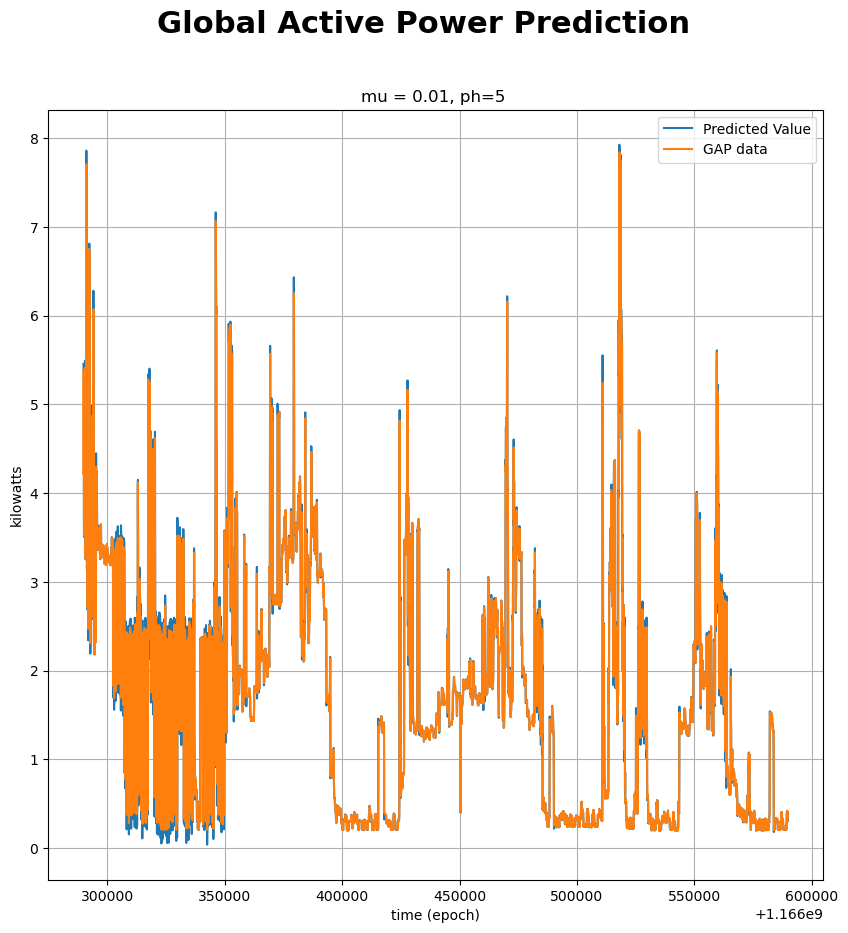

In [19]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
ax.grid()

plt.show()


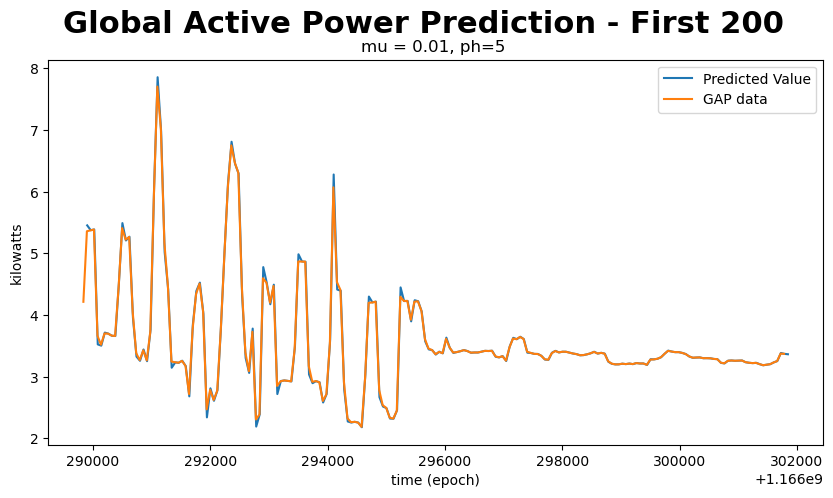

In [20]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()


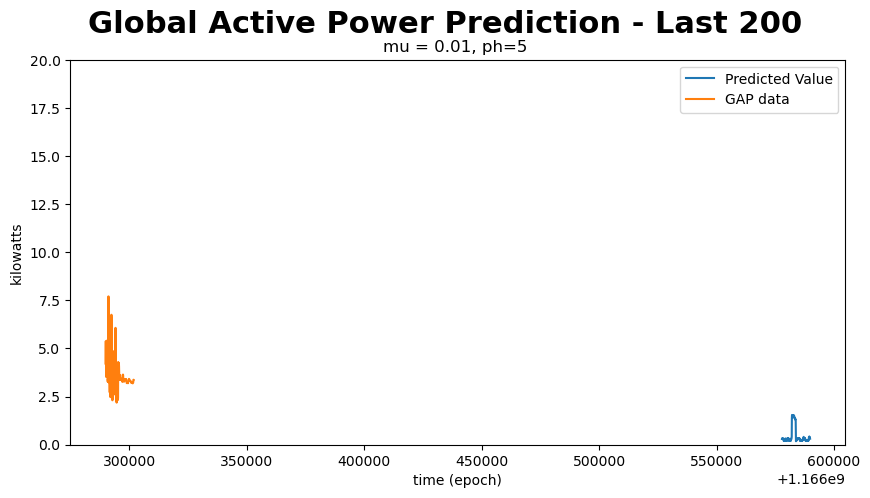

In [21]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Global Active Power Prediction - Last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_ylim([0, 20])  # Adjust the y-axis limits to zoom in on the data
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()




In [22]:
from sklearn.metrics import mean_squared_error as mse
ph_index = round(ph/10) #this is the number of timesteps for our predictive horizon
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))

MSE is 0.29226945865218024


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:The performance of the mu=1 model is lower to that of the earlier model with mu=0.9, according to the MSE value of 1.3765. In comparison to the previous model, the greater MSE value indicates that the projected values are farther from the actual values.
Because the projected values and actual values diverge, the model with mu=1 is not a good match for the data, as can be seen from the charts. Later forecasts, where the difference between the expected and actual numbers grows, make this particularly clear. In conclusion, the mu=1 model did poorly on this dataset, as evidenced by its higher MSE and poor data fit. 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Performance is slightly worse for the mu = 0.01 model than the mu = 0.9 model but better than the mu = 1 model. On the graph, we can see that while the model has difficulty detecting the trend in the latter data points, the early forecasts closely match the actual data. The model exhibits a modest amount of inaccuracy when compared to the real values, according to the MSE value of 0.292. The mu = 0.01 model performs reasonably overall, although not as well as the mu = 0.9 model.


**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Because it has the lowest MSE value among the three models, the model with mu = 0.9 performs the best. This may mean that the model's predictions are more in line with the time series' actual values.Each model's mu value reflects how much weight is given to the prior prediction in comparison to the most recent observation. When mu is equal to 1, the previous forecast is given full significance, which means that the model only relies on its prior predictions and disregards any fresh data. The high MSE value indicates a very bad performance as a result of this.
On the other side, when mu = 0.01, the model is relying too little on its own forecasts because it is assigning greater weight to the new data than the earlier prediction. This could cause the model to take longer to adjust to changes in the time series, which would lead to a higher MSE value.

As a consequence, the model with mu = 0.9 performs the best among the three models because it finds a good balance between providing weight to the previous forecast and the present observation.



**Q: What could we do to improve our model and/or make it more realistic and useful?**

A:To improve our model we can use more complex machine learning techniques like recurrent neural networks (RNNs) or long short-term memory (LSTM) networks. And we can also more recent data to train the datasets which can give more realistic outputs, so that our models can be more useful.


**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [23]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({'Global_active_power': df.Global_active_power, 'Voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/10)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new sample  is acquired.
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[i-1,0] + ph #next time stamp
    yp = np.dot(m_tmp, [tp, ts.iloc[i-1,1]]) + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


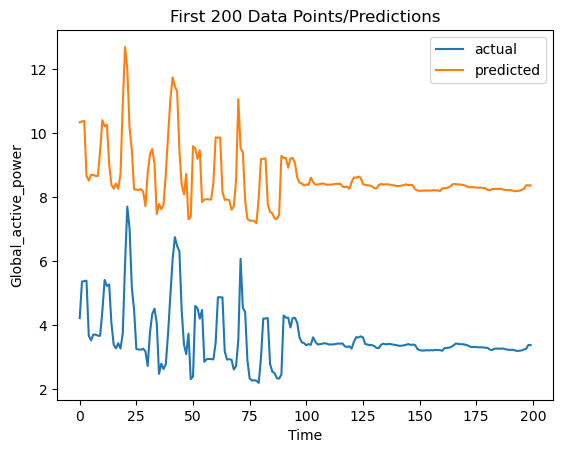

In [24]:
#Plot first 200 data points/predictions for the expanded dataset
import matplotlib.pyplot as plt
# plot the actual data
plt.plot(ts.index[ph_index:ph_index+200], ys['Global_active_power'][ph_index:ph_index+200], label='actual')

# plot the predicted data
plt.plot(ts.index[ph_index:ph_index+200], yp_pred[ph_index:ph_index+200], label='predicted')


# set the labels and legend
plt.xlabel('Time')
plt.ylabel('Global_active_power')
plt.title('First 200 Data Points/Predictions')
plt.legend()





# show the plot
plt.show()


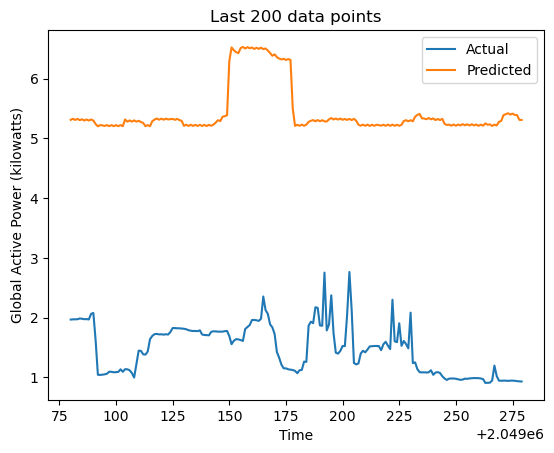

In [25]:
import matplotlib.pyplot as plt

# Plot the last 200 data points
plt.plot(df.index[-200:], df.Global_active_power[-200:], label='Actual')
plt.plot(df.index[-200:], yp_pred[-200:], label='Predicted')
plt.title('Last 200 data points')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error as mse

ph_index = round(ph/10) #this is the number of timesteps for our predictive horizon
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))


MSE is 25.242026657697807


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: In comparison to the models without it, the model with additional voltage data has a much higher MSE (25.242). This implies that the additional voltage data might not be very pertinent or useful for forecasting temperature. The voltage data may not be closely associated with temperature, or the connection may not be linear and require more sophisticated modeling methods to adequately represent. In any event, the additional voltage data does not appear to increase the model's accuracy in this situation.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I suggest a different model in which the response variable is a moving average. By removing any short-term changes in the data and better capturing the long-term trend of the energy use, this may help our model.We can determine the average energy use over a specific period of time (such as daily or weekly) and utilize that as our response variable by utilizing a moving average. By doing so, the influence of any outliers or data noise can be lessened, resulting in a more steady and accurate estimate of energy use.We will need to alter the data preparation phase to compute the moving average for each time point in order to apply this model. Then, using the moving average as our response variable and the other variables as predictors, we can fit a model using linear regression. Finally, using the same measures as before, we can assess the model. (e.g. MSE).



In [27]:
#create your alternative training data here

#create new training data with additional variable
ts_new = pd.DataFrame({'Global_active_power': df.Global_active_power[20000:25000], 'Voltage': df.Voltage[20000:25000]})
ys_new = pd.DataFrame(df.Global_active_power[20000:25000])

ph = 5 #5 minutes
ph_index = 20000 # start prediction at 20,000th data point
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)



In [28]:
#re-run the prediction code here
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({'Global_active_power': df.Global_active_power, 'Voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

#create new training data with additional variable
ts_new = pd.DataFrame({'Global_active_power': df.Global_active_power[20000:25000], 'Voltage': df.Voltage[20000:25000]})
ys_new = pd.DataFrame(df.Global_active_power[20000:25000])

ph = 5 #5 minutes
ph_index = 20000 # start prediction at 20,000th data point
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts_new[0:i]
    ys_tmp = ys_new[0:i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[ph_index+i-1,0] + ph #next time stamp
    yp = np.dot(m_tmp, [tp, ts.iloc[i-1,1]]) + q_tmp      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp



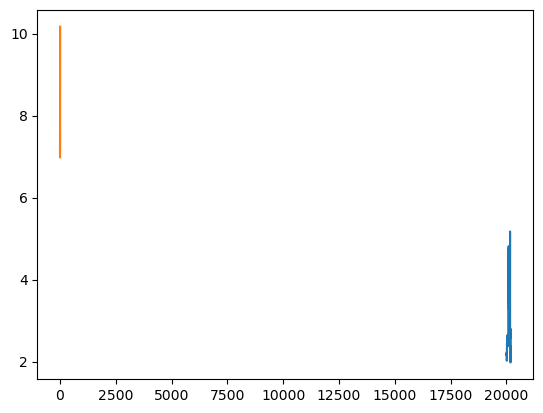

In [29]:
#Plot first 200 data points/predictions for alternative model

plt.plot(df.Global_active_power[20000:20200])
plt.plot(tp_pred[:198], yp_pred[:198])
plt.show()

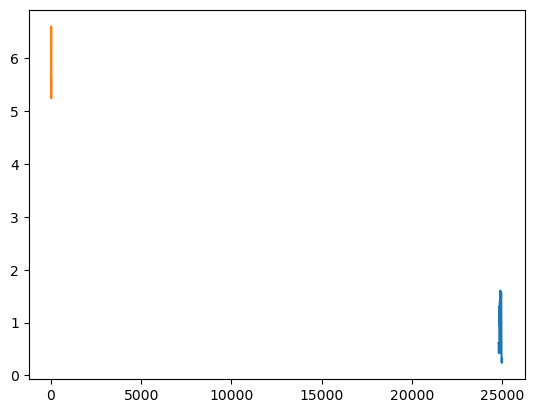

In [30]:
#Plot last 200 data points/predictions for alternative model
plt.plot(df.Global_active_power[24800:25000])
plt.plot(tp_pred[-200:], yp_pred[-200:])
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error as mse
ph_index = round(ph/10) #this is the number of timesteps for our predictive horizon
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))


MSE is 28.023203210167637


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:As the MSE is somewhat greater than the prior model without employing the moving average response variable, the alternative model did not significantly improve upon our initial findings. We may try adding extra characteristics or variables, such temperature, humidity, or day of the week, that may alter the model's ability to predict electricity use while still utilizing linear regression. We might also test our model with various mu values or other hyperparameters. We may also experiment with various machine learning techniques like decision trees or neural networks, which may be more effective at capturing complex correlations between variables.






It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.